In [1]:
import os
import scanpy as sc
from os.path import join

import sys
sys.path.insert(0, '../..')

from spamosaic.framework import SpaMosaic

In [2]:
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [3]:
data_dir = '/home/xuhua/xuhua_disco/gitrepo/BridgeNorm/SpaMosaic-release/data/integration/Human_lymph_node'

ad1_rna = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_rna.h5ad'))
ad1_adt = sc.read_h5ad(join(data_dir, 'slice1/s1_adata_adt.h5ad'))
ad2_rna = sc.read_h5ad(join(data_dir, 'slice2/s2_adata_rna.h5ad'))
ad3_adt = sc.read_h5ad(join(data_dir, 'slice3/s3_adata_adt.h5ad'))

### preprocessing

In [4]:
ad1_rna

AnnData object with n_obs × n_vars = 3484 × 18085
    obs: 'lab', 'lab_lynn', 'src', 'final_annot'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [5]:
input_dict = {
    'rna': [ad1_rna, ad2_rna, None],
    'adt': [ad1_adt, None,    ad3_adt]
}

input_key = 'dimred_bc'

In [6]:
RNA_preprocess(input_dict['rna'], batch_corr=True, favor='scanpy', n_hvg=5000, batch_key='src', key=input_key)
ADT_preprocess(input_dict['adt'], batch_corr=True, batch_key='src', key=input_key)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).
Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


### training

In [7]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', intra_knn=2, inter_knn=2, w_g=0.8, 
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, T=0.01, n_epochs=100)

batch0: ['rna', 'adt']
batch1: ['rna']
batch2: ['adt']
------Calculating spatial graph...
The graph contains 6968 edges, 3484 cells.
2.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 6718 edges, 3359 cells.
2.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 6968 edges, 3484 cells.
2.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 6816 edges, 3408 cells.
2.0000 neighbors per cell on average.
Number of mnn pairs for rna:834
Number of mnn pairs for adt:1269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.76it/s]


In [8]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


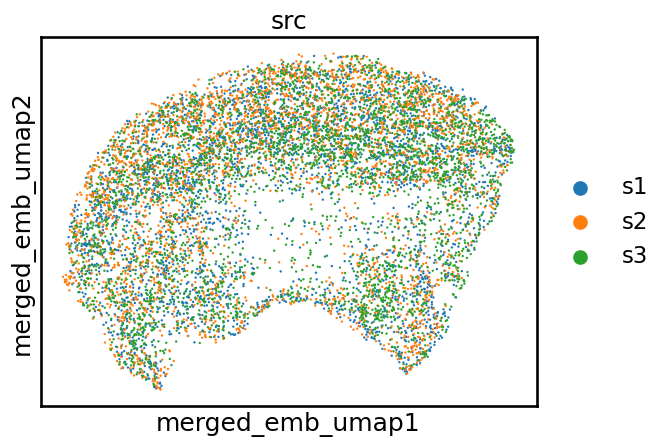

In [9]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

In [10]:
utls.clustering(ad_mosaic, n_cluster=7, used_obsm='merged_emb', algo='mclust', key='mclust')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'mclust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


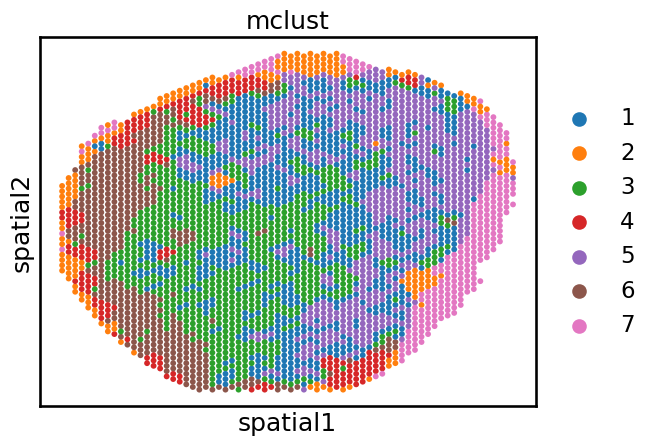

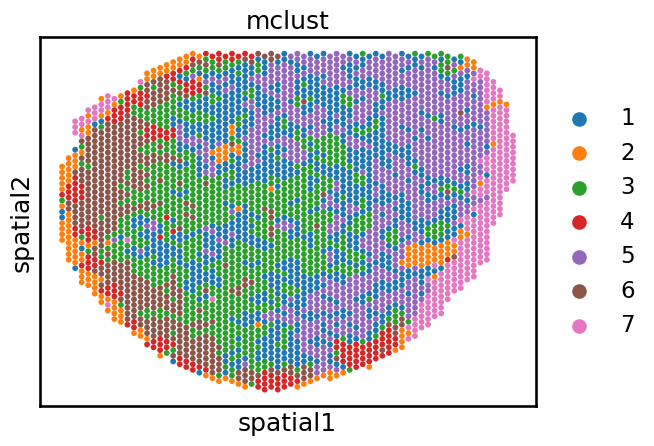

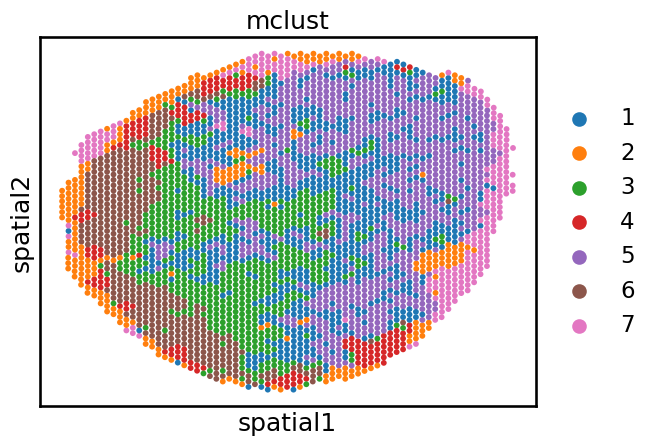

In [11]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'mclust', s=70)